# Custom Tokenizer and Embedding Implementation

This notebook implements a custom tokenizer and embedding layer from scratch. These are fundamental components in natural language processing (NLP) systems:

1. **Tokenizer**: Converts text into numerical indices by building a vocabulary from the training data. `1_build_tokenizer.ipynb` built the tokenizer.
2. **Embedding Layer**: Transforms token indices into dense vector representations that capture semantic relationships.

We'll build these components step by step and demonstrate their usage with examples.

In [1]:
from typing import Dict, List, Union, Tuple, Optional, Any
import numpy as np

class Tokenizer:
    def __init__(self, max_vocab_size: int = 10000) -> None:
        """
        Initialize a simple tokenizer with vocabulary building capabilities
        
        Args:
            max_vocab_size (int): Maximum number of unique tokens to keep
        """
        self.word_to_index: Dict[str, int] = {}
        self.index_to_word: Dict[int, str] = {}
        self.vocab_size: int = 0
        self.max_vocab_size: int = max_vocab_size
        
        # Special tokens
        self.pad_token: str = '<PAD>'
        self.unk_token: str = '<UNK>'
        self.sos_token: str = '<SOS>'  # Start of Sequence 
        self.eos_token: str = '<EOS>'  # End of Sequence
        self._add_special_tokens()
    
    def _add_to_vocab(self, word: str) -> int:
        """Add a word to the vocabulary"""
        if word not in self.word_to_index:
            # If we still can add vocab
            if self.vocab_size < self.max_vocab_size:
                self.word_to_index[word] = self.vocab_size
                self.index_to_word[self.vocab_size] = word
                self.vocab_size += 1
                # Return the latest index
                return self.word_to_index[word]
        # If the word already in the index of word if there 
        # OR max_vocab reached, return UNKNOWN Token
        return self.word_to_index.get(word, self.word_to_index[self.unk_token])

    def _add_special_tokens(self) -> None:
        """Add special tokens to the vocabulary"""
        self._add_to_vocab(self.pad_token)
        self._add_to_vocab(self.unk_token)
        self._add_to_vocab(self.sos_token)
        self._add_to_vocab(self.eos_token)

    def fit_on_texts(self, texts: List[str]) -> None:
        """
        Build vocabulary from input texts
        
        Args:
            texts (List[str]): List of sentences or documents
        """
        # Flatten and tokenize texts; split by space for simplification
        # each item is a word
        all_words: List[str] = [word for sentence in texts for word in sentence.split()]
        
        # Count word frequencies
        # Ensures most common words are included first
        word_counts: Dict[str, int] = {}
        for word in all_words:
            word_counts[word] = word_counts.get(word, 0) + 1
        
        # Sort words by frequency, descending order
        sorted_words: List[Tuple[str, int]] = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Add most frequent words to vocabulary
        for word, _ in sorted_words:
            self._add_to_vocab(word)

    def texts_to_sequences(self, texts: List[str], add_sos_eos: bool = True) -> List[List[int]]:
        """
        Convert texts to sequences of indices
        
        Args:
            texts (List[str]): List of sentences or documents
            add_sos_eos (bool): Whether to add Start and End of Sequence tokens
        
        Returns:
            List[List[int]]: List of token indices
        """
        sequences: List[List[int]] = []
        for text in texts:
            # Tokenize the text
            tokens: List[str] = text.split()
            
            # Add special tokens if requested
            if add_sos_eos:
                tokens = [self.sos_token] + tokens + [self.eos_token]
            
            # Convert to indices
            sequence: List[int] = [self.word_to_index.get(word, self.word_to_index[self.unk_token]) 
                        for word in tokens]
            sequences.append(sequence)
        
        return sequences
    
    def pad_sequences(self, sequences: List[List[int]], max_length: Optional[int] = None) -> np.ndarray:
        """
        Pad sequences to the same length
        
        Args:
            sequences (List[List[int]]): List of sequences to pad
            max_length (Optional[int]): Length to pad to. If None, uses the longest sequence.
            
        Returns:
            np.ndarray: Padded sequences as a 2D numpy array
        """
        # Find max sequence length if not provided
        if max_length is None:
            max_length = max(len(seq) for seq in sequences)
            
        # Initialize padded array with padding token
        padded_sequences = np.full((len(sequences), max_length), self.word_to_index[self.pad_token])
        
        # Fill in the actual sequences
        for i, seq in enumerate(sequences):
            # Truncate if needed
            seq_len = min(len(seq), max_length)
            padded_sequences[i, :seq_len] = seq[:seq_len]
            
        return padded_sequences

In [2]:
class Embedding:
    """
    A custom embedding layer that converts token indices to vector representations
    """
    def __init__(self, vocab_size: int, embedding_dim: int, 
                 padding_idx: Optional[int] = None) -> None:
        """
        Initialize embedding layer with random weights
        
        Args:
            vocab_size (int): Size of vocabulary (number of unique tokens)
            embedding_dim (int): Dimension of embedding vectors
            padding_idx (Optional[int]): Index of padding token to zero out
        """
        # Initialize embeddings with small random values
        self.weights: np.ndarray = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
        
        # If padding index provided, set those embeddings to zero
        if padding_idx is not None:
            self.weights[padding_idx] = np.zeros(embedding_dim)
        
        self.vocab_size: int = vocab_size
        self.embedding_dim: int = embedding_dim
    
    def forward(self, indices: Union[int, List[int], List[List[int]], np.ndarray]) -> np.ndarray:
        """
        Convert token indices to embeddings
        
        Args:
            indices: Token indices, can be a single index, a sequence (list/array),
                     or a batch of sequences (2D list/array)
            
        Returns:
            np.ndarray: Corresponding embedding vectors
        """
        # Handle single index
        if isinstance(indices, int):
            return self.weights[indices]
        
        # Handle sequence (list or 1D array)
        if isinstance(indices, list) and (not indices or not isinstance(indices[0], list)):
            return np.array([self.weights[idx] for idx in indices])
        elif isinstance(indices, np.ndarray) and indices.ndim == 1:
            return self.weights[indices]
        
        # Handle batch of sequences (2D list or 2D array)
        # This is where the error occurred - handling sequences of different lengths
        if isinstance(indices, list):
            # For batch processing of different length sequences, we'll use a different approach
            # Process each sequence separately and return them as a list
            return [np.array([self.weights[idx] for idx in seq]) for seq in indices]
        elif isinstance(indices, np.ndarray) and indices.ndim == 2:
            batch_size, seq_length = indices.shape
            result = np.zeros((batch_size, seq_length, self.embedding_dim))
            for i in range(batch_size):
                result[i] = self.weights[indices[i]]
            return result
        
        raise ValueError(f"Unsupported indices type or shape: {type(indices)}")
    
    def __call__(self, indices: Union[int, List[int], List[List[int]], np.ndarray]) -> np.ndarray:
        """
        Make the class callable for convenience
        """
        return self.forward(indices)

## Basic Tokenization Example

Let's see how our tokenizer works with some sample text data. We'll create a tokenizer, build a vocabulary, and convert texts to numerical sequences.

In [3]:
# Sample data for tokenizer
texts = [
    "the quick brown fox jumps over the lazy dog",
    "a quick brown fox jumps over a lazy dog",
    "the lazy dog sleeps all day"
]

# Create tokenizer
tokenizer = Tokenizer()

# Fit tokenizer on texts
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Print sequences
print("Vocabulary size:", tokenizer.vocab_size)
print("Word to index mapping:")
for word, idx in sorted(tokenizer.word_to_index.items(), key=lambda x: x[1]):
    print(f"  {word}: {idx}")
print("\nTokenized Sequences:")
print(sequences)

Vocabulary size: 16
Word to index mapping:
  <PAD>: 0
  <UNK>: 1
  <SOS>: 2
  <EOS>: 3
  the: 4
  lazy: 5
  dog: 6
  quick: 7
  brown: 8
  fox: 9
  jumps: 10
  over: 11
  a: 12
  sleeps: 13
  all: 14
  day: 15

Tokenized Sequences:
[[2, 4, 7, 8, 9, 10, 11, 4, 5, 6, 3], [2, 12, 7, 8, 9, 10, 11, 12, 5, 6, 3], [2, 4, 5, 6, 13, 14, 15, 3]]


## Working with Embeddings

Now we'll demonstrate how to use the embedding layer with our tokenized sequences:

In [4]:
# Create embedding layer
embedding_dim = 5  # Small dimension for demonstration
embedding = Embedding(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=embedding_dim,
    padding_idx=tokenizer.word_to_index[tokenizer.pad_token]
)

# Get embedding for a single token
token_idx = tokenizer.word_to_index.get("the", tokenizer.word_to_index[tokenizer.unk_token])
token_embedding = embedding(token_idx)
print(f"\nEmbedding for 'the' (index {token_idx}):")
print(token_embedding)
print(f"Shape: {token_embedding.shape}")


Embedding for 'the' (index 4):
[ 0.11329806 -0.1241075  -0.04422653  0.06711329  0.10363299]
Shape: (5,)


In [5]:
# Get embeddings for first sequence
first_sequence = sequences[0]
seq_embedding = embedding(first_sequence)
print(f"\nEmbeddings for first sequence:")
print(f"Sequence: {first_sequence}")
print(f"Shape: {seq_embedding.shape}")
print(f"First few embeddings:\n{seq_embedding[:3]}")


Embeddings for first sequence:
Sequence: [2, 4, 7, 8, 9, 10, 11, 4, 5, 6, 3]
Shape: (11, 5)
First few embeddings:
[[-0.1171221  -0.14677965  0.02048344 -0.170987   -0.06683971]
 [ 0.11329806 -0.1241075  -0.04422653  0.06711329  0.10363299]
 [-0.01834764  0.05104385  0.16511649  0.04451233  0.13995713]]


## Batch Processing with Padding

To process batches of sequences that may have different lengths, we'll use padding to make them uniform before embedding:

In [6]:
# Pad sequences to same length for batch processing
padded_sequences = tokenizer.pad_sequences(sequences)
print("Padded sequences shape:", padded_sequences.shape)
print("Padded sequences:\n", padded_sequences)

# Get embeddings for all sequences (batch processing)
batch_embedding = embedding(padded_sequences)
print(f"\nEmbeddings for all sequences (batch):")
print(f"Shape: {batch_embedding.shape}")
print(f"First sequence, first token embedding: {batch_embedding[0, 0, :]}")

Padded sequences shape: (3, 11)
Padded sequences:
 [[ 2  4  7  8  9 10 11  4  5  6  3]
 [ 2 12  7  8  9 10 11 12  5  6  3]
 [ 2  4  5  6 13 14 15  3  0  0  0]]

Embeddings for all sequences (batch):
Shape: (3, 11, 5)
First sequence, first token embedding: [-0.1171221  -0.14677965  0.02048344 -0.170987   -0.06683971]


In [7]:
# Demonstrate padding does have zero embeddings
pad_idx = tokenizer.word_to_index[tokenizer.pad_token]
pad_embedding = embedding(pad_idx)
print(f"\nEmbedding for padding token (should be all zeros):")
print(pad_embedding)


Embedding for padding token (should be all zeros):
[0. 0. 0. 0. 0.]


## Application: Text Encoding and Word Similarity

Let's use our tokenizer and embedding for some simple NLP tasks:

In [8]:
# Example of a simple text encoder that averages embeddings
def encode_text(text: str, tokenizer: Tokenizer, embedding: Embedding) -> np.ndarray:
    """Convert text to a fixed-length vector by averaging embeddings"""
    sequence = tokenizer.texts_to_sequences([text])[0]
    embedded = embedding(sequence)
    # Average all embeddings (excluding special tokens if desired)
    return np.mean(embedded, axis=0)

# Encode a new text
new_text = "the brown fox is quick"
text_vector = encode_text(new_text, tokenizer, embedding)
print(f"\nEncoded vector for '{new_text}':")
print(text_vector)
print(f"Shape: {text_vector.shape}")


Encoded vector for 'the brown fox is quick':
[-0.04610911  0.02681595 -0.01386664 -0.00947885  0.0176023 ]
Shape: (5,)


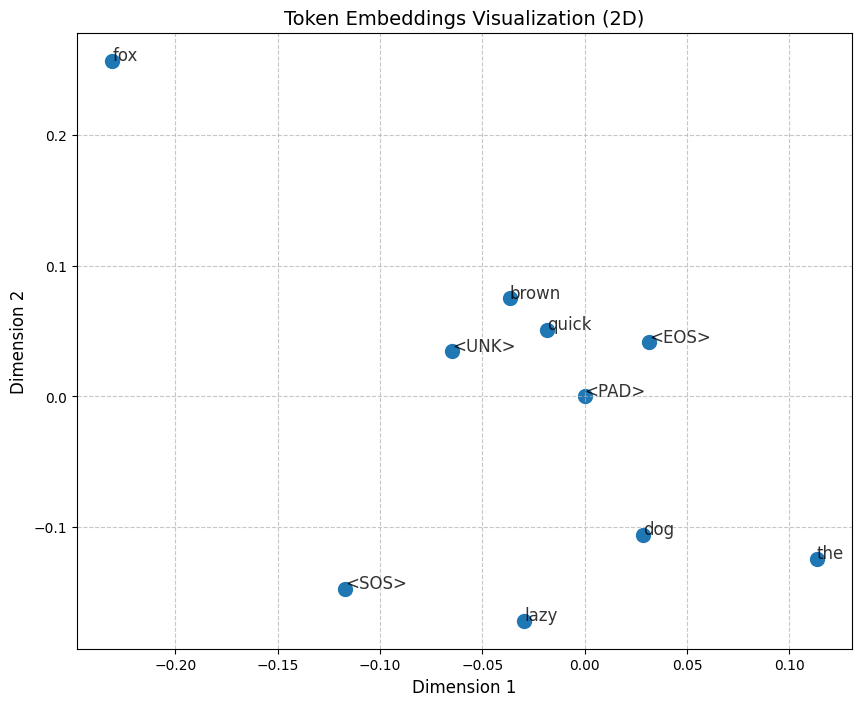

In [9]:
# Visualize embeddings for the first few tokens
import matplotlib.pyplot as plt

def plot_embeddings(tokenizer: Tokenizer, embedding: Embedding, n_tokens: int = 10) -> None:
    """Plot the first 2 dimensions of embeddings for visualization"""
    tokens = list(tokenizer.word_to_index.keys())[:n_tokens]
    indices = [tokenizer.word_to_index[token] for token in tokens]
    
    # Get embeddings for these tokens
    token_embeddings = np.array([embedding(idx) for idx in indices])
    
    # Plot first 2 dimensions
    plt.figure(figsize=(10, 8))
    plt.scatter(token_embeddings[:, 0], token_embeddings[:, 1], s=100)
    
    # Label each point with the token
    for i, token in enumerate(tokens):
        plt.annotate(token, (token_embeddings[i, 0], token_embeddings[i, 1]), 
                     fontsize=12, alpha=0.8)
    
    plt.title('Token Embeddings Visualization (2D)', fontsize=14)
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Visualize embeddings
plot_embeddings(tokenizer, embedding)

In [10]:
# Advanced: Using embeddings for simple word similarity
def word_similarity(word1: str, word2: str, tokenizer: Tokenizer, embedding: Embedding) -> Union[str, float]:
    """Calculate cosine similarity between word embeddings"""
    if word1 not in tokenizer.word_to_index or word2 not in tokenizer.word_to_index:
        return "One or both words not in vocabulary"
    
    # Get word indices
    idx1 = tokenizer.word_to_index[word1]
    idx2 = tokenizer.word_to_index[word2]
    
    # Get embeddings
    emb1 = embedding(idx1)
    emb2 = embedding(idx2)
    
    # Calculate cosine similarity
    dot_product = np.dot(emb1, emb2)
    norm1 = np.linalg.norm(emb1)
    norm2 = np.linalg.norm(emb2)
    
    return dot_product / (norm1 * norm2)

# Calculate similarity between pairs of words
word_pairs = [
    ('quick', 'brown'),
    ('fox', 'dog'),
    ('lazy', 'sleeps')
]

print("\nWord similarities:")
for word1, word2 in word_pairs:
    similarity = word_similarity(word1, word2, tokenizer, embedding)
    print(f"Similarity between '{word1}' and '{word2}': {similarity:.4f}")


Word similarities:
Similarity between 'quick' and 'brown': -0.0952
Similarity between 'fox' and 'dog': -0.5933
Similarity between 'lazy' and 'sleeps': -0.4721


## Conclusion

In this notebook, we've built and demonstrated a complete custom tokenizer and embedding implementation. These components form the foundation of many NLP models. Our implementation includes:

1. Vocabulary building from text data
2. Text-to-sequence conversion
3. Sequence padding for batch processing
4. Token embedding generation
5. Simple applications like text encoding and word similarity

For real-world applications, you would typically use more sophisticated tokenization methods (subword tokenizers like BPE or WordPiece) and pre-trained embeddings (like Word2Vec, GloVe, or contextual embeddings from transformer models). However, this implementation provides a good foundation for understanding the core concepts.